## Stock Price Prediction

In [ ]:
!pip install -q yfinance

In [ ]:
#Importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential, load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Importing dataset

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    

company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2018-04-30,40.532501,41.814999,40.459999,41.314999,39.386463,169709600,APPLE
2018-05-01,41.602501,42.299999,41.317501,42.275002,40.301647,214277600,APPLE
2018-05-02,43.807499,44.437500,43.450001,44.142502,42.081978,266157600,APPLE
2018-05-03,43.970001,44.375000,43.610001,44.222500,42.158241,136272800,APPLE
2018-05-04,44.562500,46.062500,44.542500,45.957500,43.812260,224805200,APPLE


### Data Information

In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1.004000e+03
mean,154.579824,156.775112,152.545468,154.753145,154.381947,5.278256e+07
std,63.459766,64.067227,62.840333,63.524932,63.076805,3.193163e+07
min,82.800003,83.480003,81.430000,81.820000,81.820000,8.567800e+06
25%,103.947498,105.901249,102.438873,104.280003,104.280003,2.665858e+07
50%,133.980003,135.860001,132.130005,133.709999,133.709999,4.601100e+07
75%,184.700001,187.214996,183.197495,184.475002,183.774982,7.056310e+07
max,296.700012,305.170013,295.269989,304.829987,304.829987,2.726620e+08


In [ ]:
# showing column wise %ge of NaN values they contains 

for i in df.columns:
  print(i,"\t-\t", df[i].isna().mean()*100)


Open 	-	 0.0
High 	-	 0.0
Low 	-	 0.0
Close 	-	 0.0
Adj Close 	-	 0.0


In [ ]:
df = AAPL   # Choosin stock values for any company 

> Since there is no null valus, we can move further 

Text(0.5, 1.0, 'Stock Price with Moving Averages')

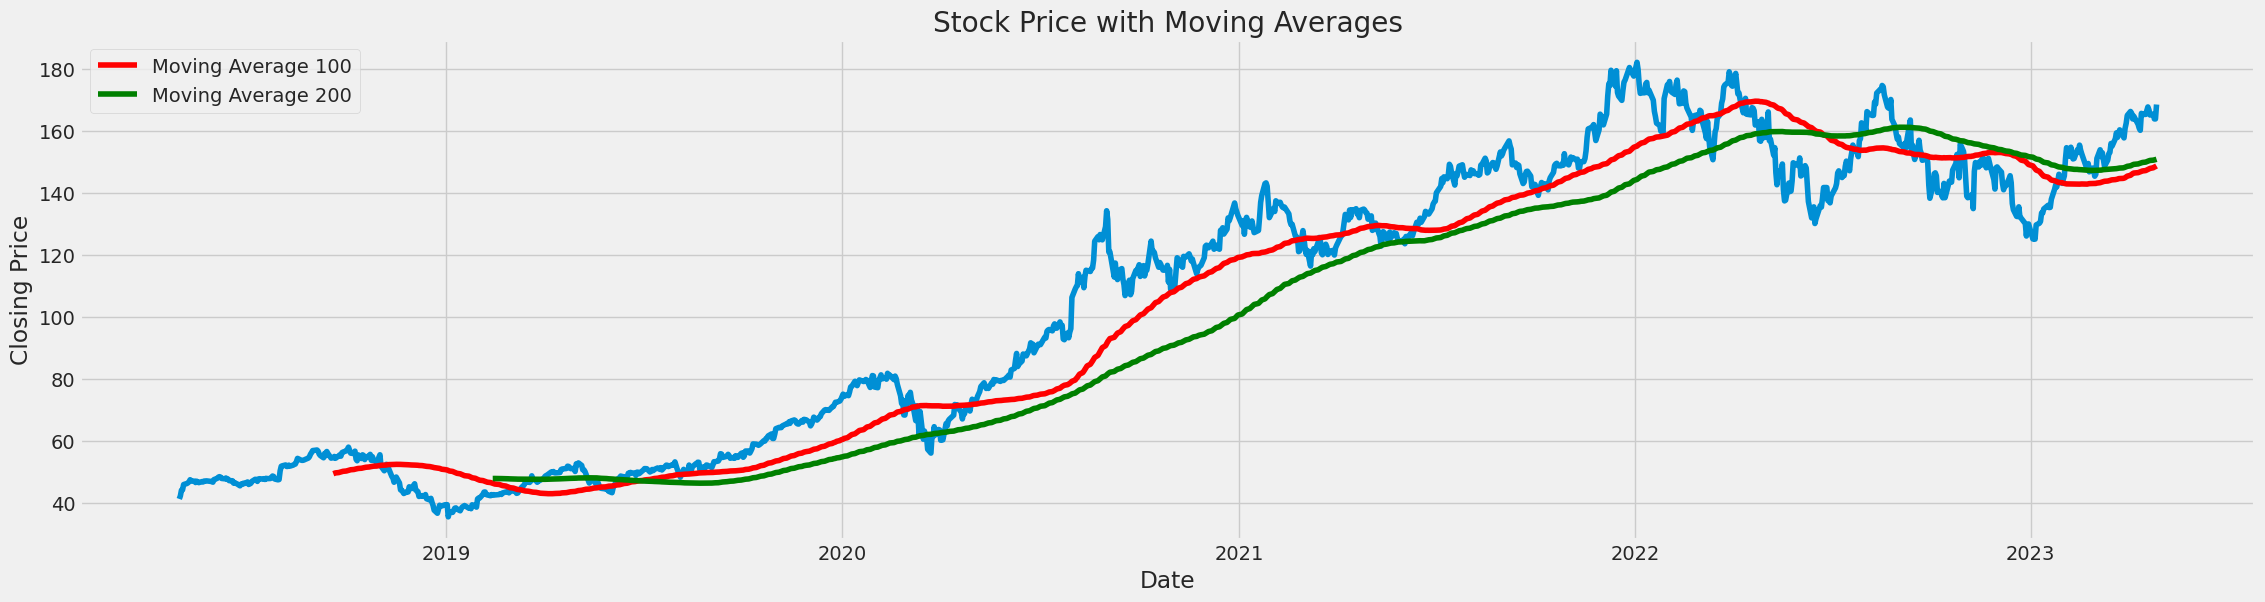

In [ ]:
#Plotting the MA 100+200
#Implementing 100day moving average
ma100 = df.Close.rolling(100).mean()
#Implementing 200day moving average
ma200 = df.Close.rolling(200).mean()
plt.figure(figsize= (25, 100))
plt.subplots_adjust(top=1.25, bottom=1.2)
plt.plot(df.Close)
plt.plot(ma100, 'r', label='Moving Average 100')
plt.plot(ma200, 'g', label='Moving Average 200')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Price with Moving Averages')

<ipython-input-84-138503d5cada>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cormap = df.corr()


<Axes: >

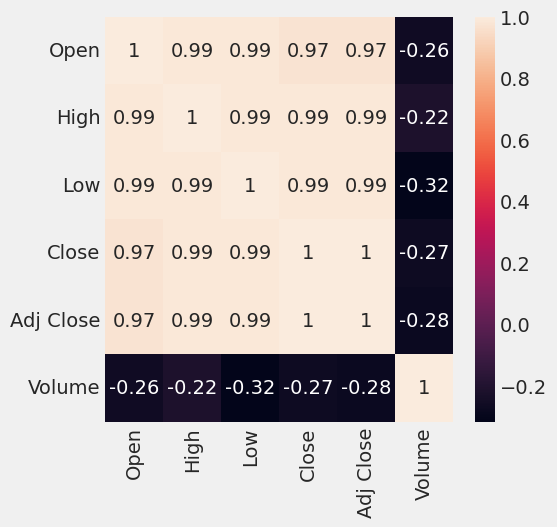

In [ ]:
cormap = df.corr()
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cormap, annot = True)

In [ ]:
def get_corelated_col(cor_dat, threshold): 
  # Cor_data to be column along which corelation to be measured 
  #Threshold be the value above which of corelation to considered
  feature=[]
  value=[]

  for i ,index in enumerate(cor_dat.index):
    if abs(cor_dat[index]) > threshold:
      feature.append(index)
      value.append(cor_dat[index])

  df = pd.DataFrame(data = value, index = feature, columns=['corr value'])
  return df


In [ ]:
top_corelated_values = get_corelated_col(cormap['Close'], 0.60)
top_corelated_values

,corr value
Open,0.970042
High,0.987715
Low,0.988922
Close,1.000000
Adj Close,0.999700


> Looks like all colums except _volume_ are ***highly co-related***. Using them for predictions.

In [ ]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close'], dtype='object')

In [ ]:
df = df[top_corelated_values.index]
df.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2018-04-30,40.532501,41.814999,40.459999,41.314999,39.386463
2018-05-01,41.602501,42.299999,41.317501,42.275002,40.301647
2018-05-02,43.807499,44.437500,43.450001,44.142502,42.081978
2018-05-03,43.970001,44.375000,43.610001,44.222500,42.158241
2018-05-04,44.562500,46.062500,44.542500,45.957500,43.812260


In [ ]:
df.shape

(1258, 5)

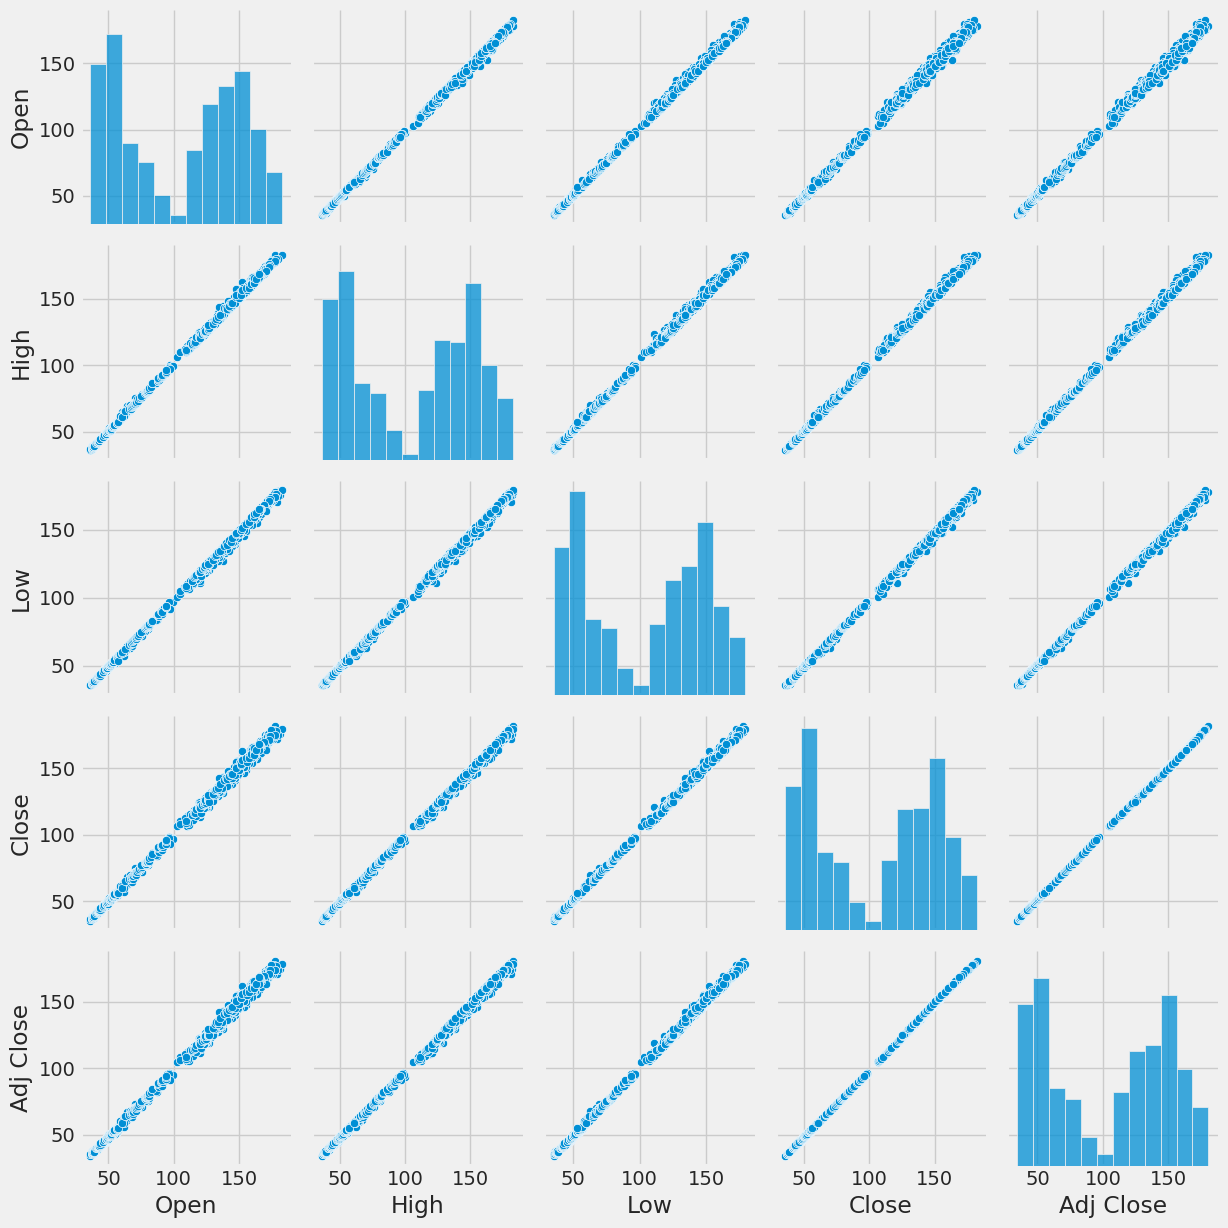

In [ ]:
sns.pairplot(df)
plt.tight_layout()

> Since other parameters have linear relationship with __close__, we are using some linear models fore prediction

In [ ]:
X = df.drop(['Close'], axis=1)
y = df['Close']

> Since range of data in different columns veries significantly we need to scale the independent variable i.e. X. For this we will use Min-Max Scaling.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,Open,High,Low,Adj Close
0,0.030944,0.036755,0.034536,0.035029
1,0.038241,0.040066,0.040506,0.041279
2,0.053279,0.054655,0.055354,0.053438
3,0.054387,0.054228,0.056468,0.053959
4,0.058427,0.065746,0.062961,0.065254


## Prediction Model

In [ ]:
#now lets split data in test train pairs

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

Acc = []

### 1. Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

# model training

model_1 = LinearRegression()
model_1.fit(X_train, y_train)

LinearRegression()

In [ ]:
# prediction
y_pred_1 = model_1.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_1})
pred_df.head()

,Actual,Predicted
Date,,
2022-04-27,156.570007,157.117407
2022-04-28,163.639999,163.908856
2022-04-29,157.649994,158.401831
2022-05-02,157.960007,158.071036
2022-05-03,159.479996,159.756036


In [ ]:
# Measure the Accuracy Score

from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_1)))
Acc.append(r2_score(y_test, y_pred_1))

Accuracy score of the predictions: 0.9924261047149868


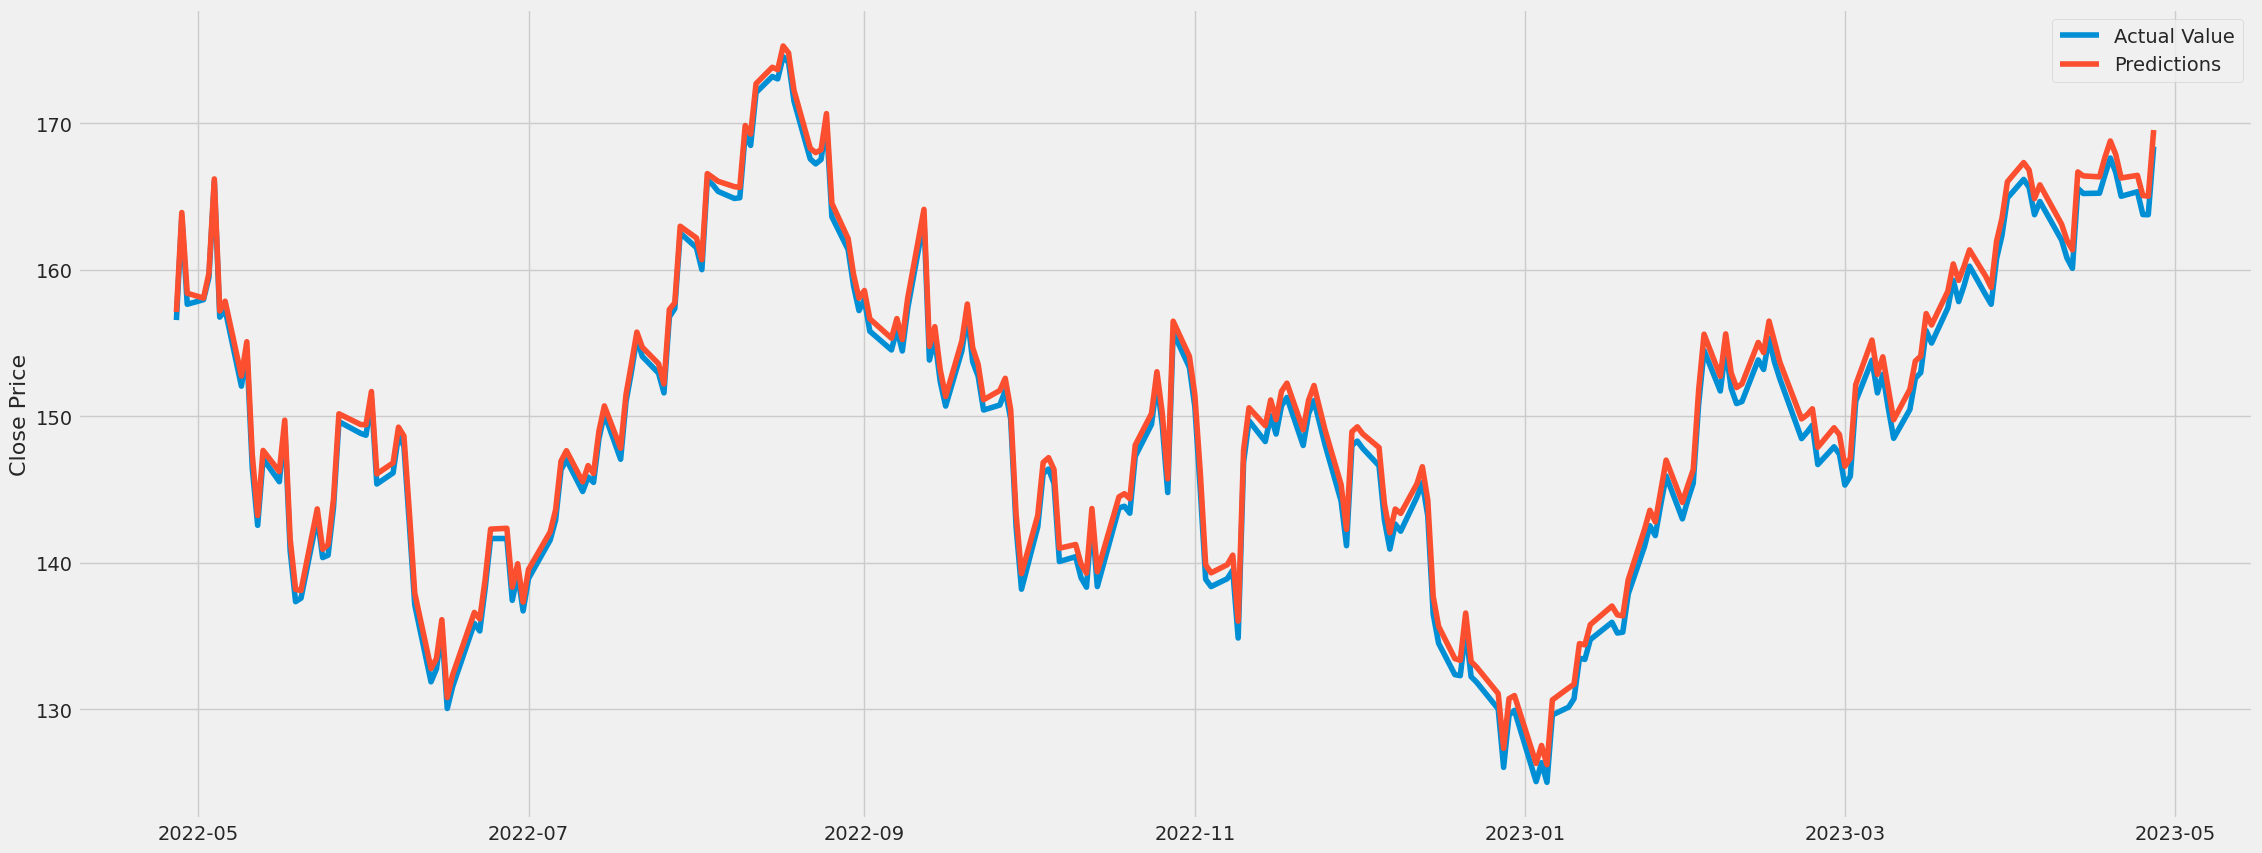

In [ ]:
plt.figure(figsize=(25,10))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred_1)
rmse = mean_squared_error(y_test, y_pred_1, squared=False)

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.9006001986565326
RMSE: 0.9367214108305143


### 2. ANN

In [ ]:
# Model Creation

from keras.models import Sequential
from keras.layers import Dense

def regressor(inp_dim):
    
    model = Sequential()
    
    model.add(Dense(20, input_dim=inp_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(25, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [ ]:
# Model Training

model_2 = regressor(inp_dim=4)
model_2.fit(X_train, y_train, epochs=70, validation_split=0.2)

Epoch 1/70
5/5 [==============================] - 1s 45ms/step - loss: 22541.4688 - val_loss: 19199.0410
Epoch 2/70
5/5 [==============================] - 0s 10ms/step - loss: 22539.8828 - val_loss: 19197.5703
Epoch 3/70
5/5 [==============================] - 0s 9ms/step - loss: 22538.2598 - val_loss: 19196.0664
Epoch 4/70
5/5 [==============================] - 0s 13ms/step - loss: 22536.5820 - val_loss: 19194.5059
Epoch 5/70
5/5 [==============================] - 0s 13ms/step - loss: 22534.8340 - val_loss: 19192.8789
Epoch 6/70
5/5 [==============================] - 0s 10ms/step - loss: 22532.9844 - val_loss: 19191.1543
Epoch 7/70
5/5 [==============================] - 0s 10ms/step - loss: 22530.9844 - val_loss: 19189.3047
Epoch 8/70
5/5 [==============================] - 0s 10ms/step - loss: 22528.7930 - val_loss: 19187.2871
Epoch 9/70
5/5 [==============================] - 0s 9ms/step - loss: 22526.3398 - val_loss: 19185.0508
Epoch 10/70
5/5 [==============================] - 0s 15m

In [ ]:
# Prediction

y_pred_2 = model_2.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [ ]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_2.flatten()})
pred_df.head()

,Actual,Predicted
Date,,
2023-02-14,153.199997,81.042793
2023-02-15,155.330002,84.431938
2023-02-16,153.710007,84.543190
2023-02-17,152.550003,80.465309
2023-02-21,148.479996,75.384277


In [ ]:
# Measure the Accuracy Score

from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_2)))
#Acc.append(r2_score(y_test, y_pred_2))

Accuracy score of the predictions: -96.58929358886536


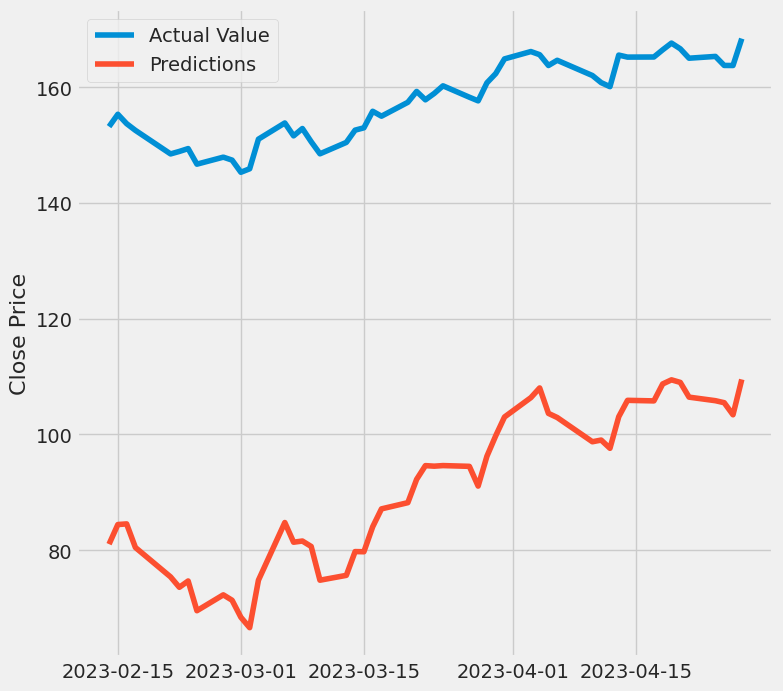

In [ ]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

### 3. CNN

In [ ]:
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout

def reg():
    
    model = Sequential()
    
    model.add(Conv1D(32, kernel_size=(3,), padding='same', activation='relu', input_shape = (X_train.shape[1],1)))
    model.add(Conv1D(64, kernel_size=(3,), padding='same', activation='relu'))
    model.add(Conv1D(128, kernel_size=(5,), padding='same', activation='relu'))
    
    model.add(Flatten())
    
    model.add(Dense(50, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(units = 1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [ ]:
# Model Training

model_3 = reg()
model_3.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
5/5 [==============================] - 1s 54ms/step - loss: 22496.0508 - val_loss: 19132.8711
Epoch 2/100
5/5 [==============================] - 0s 14ms/step - loss: 22342.0781 - val_loss: 18983.4062
Epoch 3/100
5/5 [==============================] - 0s 12ms/step - loss: 21970.9062 - val_loss: 18619.2617
Epoch 4/100
5/5 [==============================] - 0s 12ms/step - loss: 21122.3105 - val_loss: 17787.9316
Epoch 5/100
5/5 [==============================] - 0s 12ms/step - loss: 19272.1152 - val_loss: 16013.1201
Epoch 6/100
5/5 [==============================] - 0s 13ms/step - loss: 15598.8750 - val_loss: 12599.2139
Epoch 7/100
5/5 [==============================] - 0s 14ms/step - loss: 9502.0430 - val_loss: 7110.5049
Epoch 8/100
5/5 [==============================] - 0s 17ms/step - loss: 2647.4446 - val_loss: 1801.3518
Epoch 9/100
5/5 [==============================] - 0s 16ms/step - loss: 2122.1973 - val_loss: 1162.9915
Epoch 10/100
5/5 [==============================] - 

In [ ]:
# Prediction

y_pred_3 = model_3.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [ ]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_3.flatten()})
pred_df.head()

,Actual,Predicted
Date,,
2023-02-14,153.199997,152.497330
2023-02-15,155.330002,154.162415
2023-02-16,153.710007,154.339081
2023-02-17,152.550003,152.203690
2023-02-21,148.479996,149.798904


In [ ]:
# Measure the Accuracy Score

from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_3)))
#Acc.append(r2_score(y_test, y_pred_3))

Accuracy score of the predictions: 0.9815473746926259


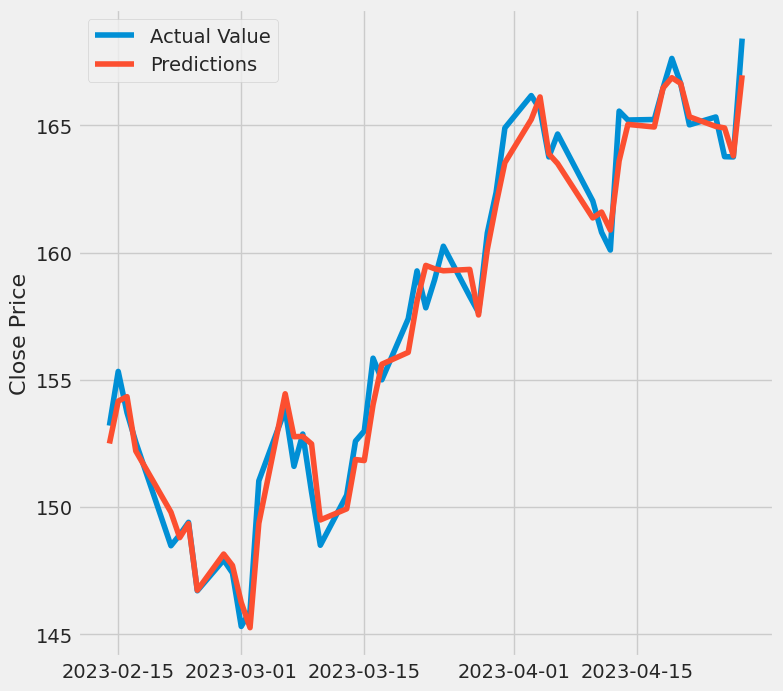

In [ ]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

> Comparision of Accuracies of different models

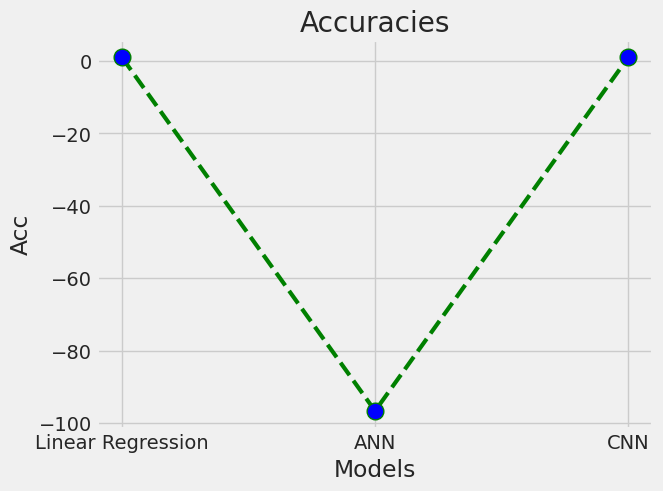

In [ ]:
plt.plot(range(3), Acc, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
plt.ylabel('Acc')
plt.xlabel('Models')
plt.title("Accuracies")
plt.xticks(range(3), ['Linear Regression', 'ANN', 'CNN'])
plt.show()

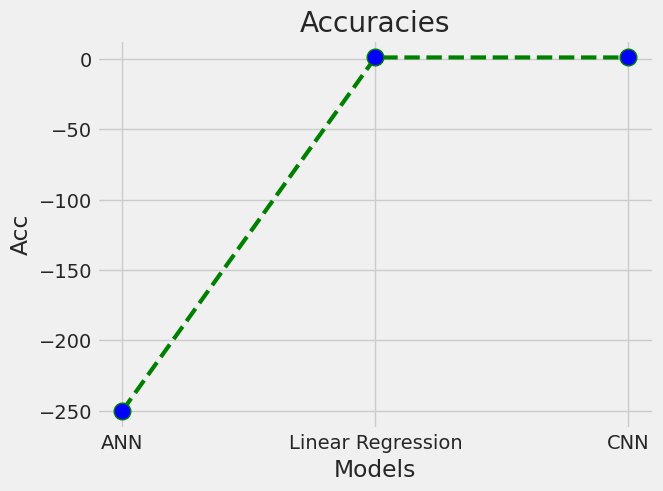

In [ ]:
plt.plot(range(3), Acc, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
plt.ylabel('Acc')
plt.xlabel('Models')
plt.title("Accuracies")
plt.xticks(range(3), ['ANN', 'Linear Regression', 'CNN'])
plt.show()

**********************

### Now converting data in a time series data and applying some more models.

In [ ]:
close = df.reset_index()['Close']
close.head()

0    156.570007
1    163.639999
2    157.649994
3    157.960007
4    159.479996
Name: Close, dtype: float64

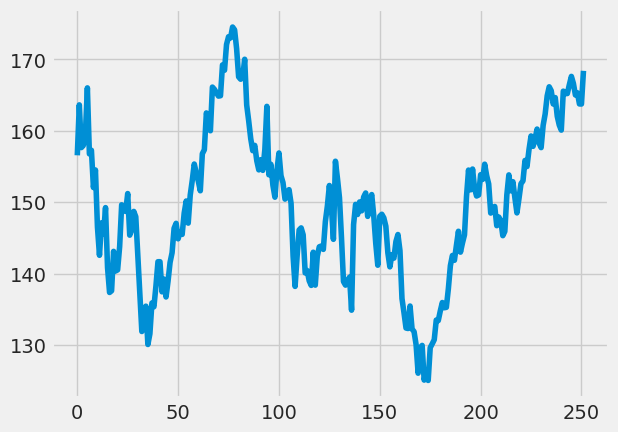

In [ ]:
plt.plot(close)
plt.show()

In [ ]:
time_step = 30
X, y = [], []

for i in range(len(close)-time_step-1):
    X.append(close[i:(i+time_step)])
    y.append(close[(i+time_step)])

X = np.array(X)
y = np.array(y)

In [ ]:
X[:5]

array([[40.380001, 40.139999, 40.490002, 40.48    , 40.639999, 40.240002,
        39.540001, 40.09    , 39.560001, 39.310001, 39.5     , 39.16    ,
        39.23    , 39.740002, 40.5     , 40.549999, 40.59    , 39.77    ,
        39.450001, 40.490002, 41.189999, 41.189999, 40.93    , 40.720001,
        40.810001, 41.57    , 42.330002, 42.549999, 42.810001, 42.630001],
       [40.139999, 40.490002, 40.48    , 40.639999, 40.240002, 39.540001,
        40.09    , 39.560001, 39.310001, 39.5     , 39.16    , 39.23    ,
        39.740002, 40.5     , 40.549999, 40.59    , 39.77    , 39.450001,
        40.490002, 41.189999, 41.189999, 40.93    , 40.720001, 40.810001,
        41.57    , 42.330002, 42.549999, 42.810001, 42.630001, 42.880001],
       [40.490002, 40.48    , 40.639999, 40.240002, 39.540001, 40.09    ,
        39.560001, 39.310001, 39.5     , 39.16    , 39.23    , 39.740002,
        40.5     , 40.549999, 40.59    , 39.77    , 39.450001, 40.490002,
        41.189999, 41.189999, 40.93 

In [ ]:
y[:5]

array([142.63999939, 137.13000488, 131.88000488, 132.75999451,
       135.42999268])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.636988,0.779729,0.658793,0.665052,0.695740,0.827781,0.641026,0.651322,0.545932,0.595397,...,0.312942,0.378760,0.497072,0.480921,0.478296,0.528771,0.411064,0.426408,0.478296,0.463154
1,0.779729,0.658793,0.665052,0.695740,0.827781,0.641026,0.651322,0.545932,0.595397,0.433677,...,0.378760,0.497072,0.480921,0.478296,0.528771,0.411064,0.426408,0.478296,0.463154,0.355744
2,0.658793,0.665052,0.695740,0.827781,0.641026,0.651322,0.545932,0.595397,0.433677,0.354129,...,0.497072,0.480921,0.478296,0.528771,0.411064,0.426408,0.478296,0.463154,0.355744,0.244498
3,0.665052,0.695740,0.827781,0.641026,0.651322,0.545932,0.595397,0.433677,0.354129,0.445992,...,0.480921,0.478296,0.528771,0.411064,0.426408,0.478296,0.463154,0.355744,0.244498,0.138502
4,0.695740,0.827781,0.641026,0.651322,0.545932,0.595397,0.433677,0.354129,0.445992,0.414294,...,0.478296,0.528771,0.411064,0.426408,0.478296,0.463154,0.355744,0.244498,0.138502,0.156269


## Prediction

In [ ]:
#now lets split data in test train pairs

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

#Acc = []

### 1. LSTM

In [ ]:
import numpy as np
X_train_ = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_ = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
from tensorflow.keras.layers import LSTM

def Reg():
    model = Sequential()
    
    model.add(LSTM(70, return_sequences=True, input_shape=(30,1)))
    model.add(LSTM(70, return_sequences=True))
    model.add(LSTM(70))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [ ]:
# Model Training
model_1 = reg()
model_1.fit(X_train_, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
26/26 [==============================] - 2s 13ms/step - loss: 6245.1494 - val_loss: 9716.1660
Epoch 2/100
26/26 [==============================] - 0s 7ms/step - loss: 613.0070 - val_loss: 554.2699
Epoch 3/100
26/26 [==============================] - 0s 7ms/step - loss: 46.5645 - val_loss: 15.8032
Epoch 4/100
26/26 [==============================] - 0s 6ms/step - loss: 4.2658 - val_loss: 2.0310
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 0.9977 - val_loss: 4.3702
Epoch 6/100
26/26 [==============================] - 0s 7ms/step - loss: 0.5714 - val_loss: 3.0995
Epoch 7/100
26/26 [==============================] - 0s 7ms/step - loss: 0.5447 - val_loss: 2.5459
Epoch 8/100
26/26 [==============================] - 0s 7ms/step - loss: 0.5329 - val_loss: 2.9271
Epoch 9/100
26/26 [==============================] - 0s 7ms/step - loss: 0.5407 - val_loss: 2.5111
Epoch 10/100
26/26 [==============================] - 0s 6ms/step - loss: 0.5290 - val_loss: 3.3

In [ ]:
# Prediction

y_pred_1 = model_1.predict(X_test_)

8/8 [==============================] - 0s 4ms/step


In [ ]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_1.flatten()})
pred_df.head()

,Actual,Predicted
Date,,
2022-04-27,156.570007,157.343979
2022-04-28,163.639999,162.179657
2022-04-29,157.649994,160.938614
2022-05-02,157.960007,156.689682
2022-05-03,159.479996,159.005325


In [ ]:
# Measure the Accuracy Score

from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_1)))
Acc.append(r2_score(y_test, y_pred_1))

Accuracy score of the predictions: 0.9867912360446339


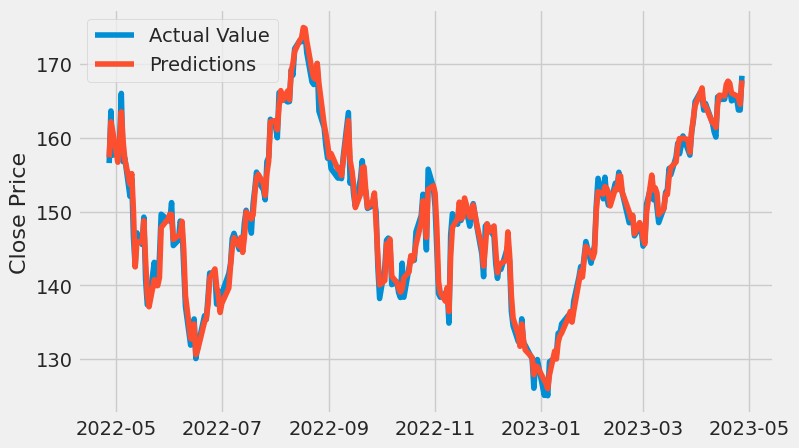

In [ ]:
plt.figure(figsize=(8,5))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred_1)
rmse = mean_squared_error(y_test, y_pred_1, squared=False)

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.9904837532648965
RMSE: 1.2370347181727066


### 2. ANN

In [ ]:
# Model Training

model_2 = regressor(inp_dim=4)
model_2.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
26/26 [==============================] - 1s 9ms/step - loss: 7094.3530 - val_loss: 25401.8398
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 7084.0449 - val_loss: 25352.0117
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 7049.1680 - val_loss: 25156.8691
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 6941.0972 - val_loss: 24552.1211
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 6650.2866 - val_loss: 23084.2305
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 6037.0400 - val_loss: 20171.1309
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 4958.8291 - val_loss: 15473.8711
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 3408.7822 - val_loss: 9468.3418
Epoch 9/100
26/26 [==============================] - 0s 4ms/step - loss: 1725.1906 - val_loss: 3890.8262
Epoch 10/100
26/26 [============================

In [ ]:
# Prediction

y_pred_2 = model_2.predict(X_test)

8/8 [==============================] - 0s 2ms/step


In [ ]:
# Measure the Accuracy Score

from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_2)))
Acc.append(r2_score(y_test, y_pred_2))

Accuracy score of the predictions: 0.9840282947220645


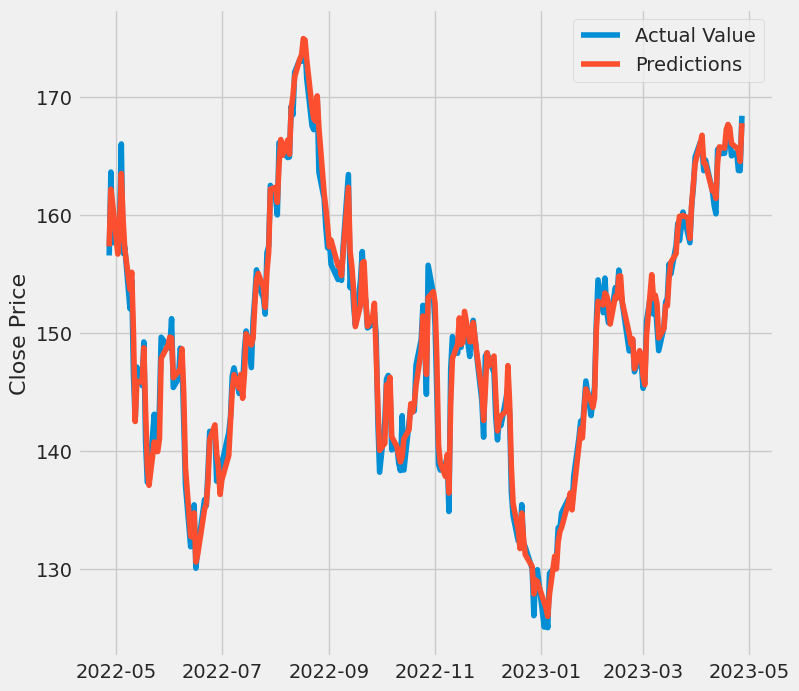

In [ ]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

In [ ]:
#Calculating the Error
mae = mean_absolute_error(y_test, y_pred_2)
rmse = mean_squared_error(y_test, y_pred_2, squared=False)

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 1.0688515920487662
RMSE: 1.3602741429081198


### 3. CNN

In [ ]:
# Model Training

model_3 = reg()
model_3.fit(X_train_, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
26/26 [==============================] - 2s 13ms/step - loss: 6589.0093 - val_loss: 14907.8252
Epoch 2/100
26/26 [==============================] - 0s 7ms/step - loss: 1027.1067 - val_loss: 925.3129
Epoch 3/100
26/26 [==============================] - 0s 7ms/step - loss: 74.6604 - val_loss: 91.1628
Epoch 4/100
26/26 [==============================] - 0s 8ms/step - loss: 7.0811 - val_loss: 7.8541
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 1.0473 - val_loss: 1.8367
Epoch 6/100
26/26 [==============================] - 0s 7ms/step - loss: 0.6117 - val_loss: 1.9547
Epoch 7/100
26/26 [==============================] - 0s 8ms/step - loss: 0.5968 - val_loss: 2.0189
Epoch 8/100
26/26 [==============================] - 0s 7ms/step - loss: 0.5768 - val_loss: 2.2260
Epoch 9/100
26/26 [==============================] - 0s 7ms/step - loss: 0.6063 - val_loss: 1.8370
Epoch 10/100
26/26 [==============================] - 0s 7ms/step - loss: 0.5918 - val_loss: 1

In [ ]:
# Prediction

y_pred_3 = model_3.predict(X_test_)

8/8 [==============================] - 0s 4ms/step


In [ ]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_3.flatten()})
pred_df.head()

,Actual,Predicted
Date,,
2022-04-27,156.570007,158.930954
2022-04-28,163.639999,163.617203
2022-04-29,157.649994,162.730179
2022-05-02,157.960007,158.151993
2022-05-03,159.479996,160.501068


In [ ]:
# Measure the Accuracy Score

from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_3)))
Acc.append(r2_score(y_test, y_pred_3))

Accuracy score of the predictions: 0.960338889127111


In [ ]:
print(Acc)

[0.9924261047149868, 0.9867912360446339, 0.9840282947220645, 0.960338889127111]


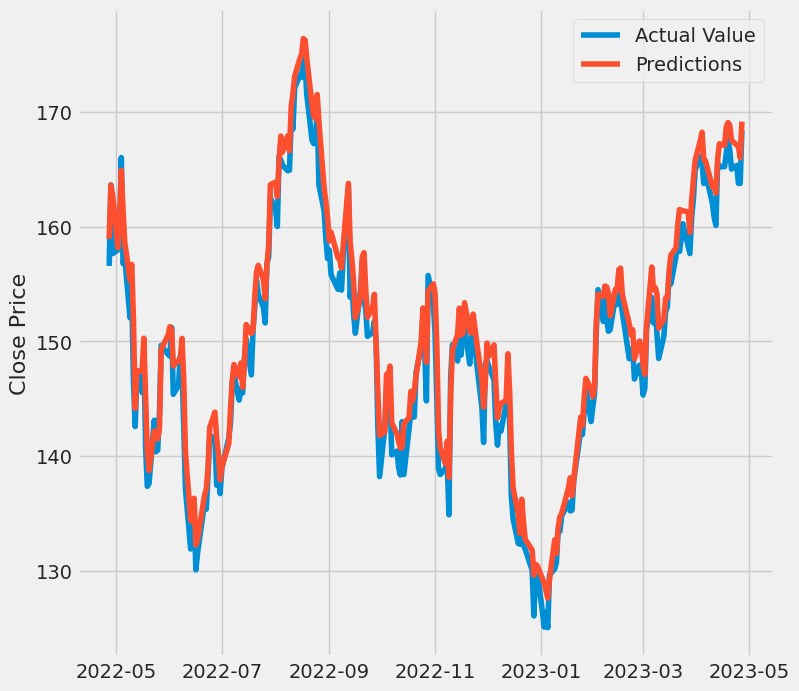

In [ ]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

In [ ]:
mae = mean_absolute_error(y_test, y_pred_3)
rmse = mean_squared_error(y_test, y_pred_3, squared=False)

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 1.8198088691348122
RMSE: 2.1435481136354695


> Comparision of Accuracies of different models

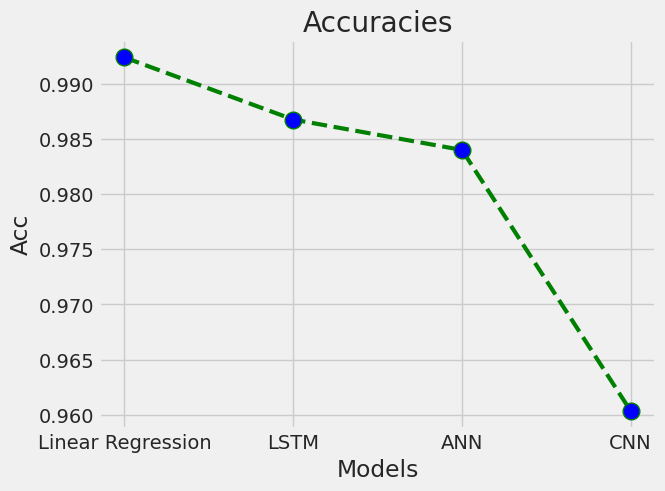

In [ ]:
plt.plot(range(4), Acc, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
plt.ylabel('Acc')
plt.xlabel('Models')
plt.title("Accuracies")
plt.xticks(range(4), ['Linear Regression', 'LSTM', 'ANN', 'CNN'])
plt.show()